In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import timeit
import zipfile
from numpy import genfromtxt
import pandas as pd
import seaborn as sns

In [2]:
from lolopy.learners import RandomForestClassifier as loloClassifier # lolopy Random forest
from sklearn.ensemble import RandomForestClassifier # scikit learn Random Forest
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn import svm
from sklearn.decomposition import PCA

In [3]:
cdir = os.getcwd()
print(cdir)
zip_dir = '/home/vazumah/AIML24787-Project/'
os.chdir(zip_dir)

/home/vazumah


In [4]:
def nucleotide_pore_data(name='mxene'):
    
    # load adenosine dataset
    A_x = genfromtxt(f'./ML Final Project Data/a_{name}.csv',delimiter=',')
    A_x_clean = A_x[1:, 1:]
    A_y = np.zeros([A_x_clean.shape[0],1])
    A_x_p= np.zeros([A_x_clean.shape[0],1])  # 'Purine'
    
    # load cytosine dataset
    C_x = genfromtxt(f'./ML Final Project Data/c_{name}.csv',delimiter=',')
    C_x_clean = C_x[1:, 1:]
    C_y = np.ones([C_x_clean.shape[0],1])
    C_x_p= np.ones([C_x_clean.shape[0],1]) #'Pyrimidine'
    
    # load guanine dataset
    G_x = genfromtxt(f'./ML Final Project Data/g_{name}.csv',delimiter=',')
    G_x_clean = G_x[1:, 1:]
    G_y = np.zeros([G_x_clean.shape[0],1])
    G_y[:]= 2
    G_x_p= np.zeros([G_x_clean.shape[0],1]) #'Purine'
    
    #load thyiamine dataset
    T_x = genfromtxt(f'./ML Final Project Data/t_{name}.csv',delimiter=',')
    T_x_clean = T_x[1:, 1:]
    T_y = np.zeros([T_x_clean.shape[0],1])
    T_y[:] = 3
    T_x_p= np.ones([T_x_clean.shape[0],1]) #'Pyrimidine'
    
    X = np.concatenate((A_x_clean, C_x_clean,G_x_clean,T_x_clean), axis=0)
    y = np.concatenate((A_y, C_y,G_y,T_y), axis=0)
    dna_class = np.concatenate((A_x_p, C_x_p,G_x_p,T_x_p), axis=0)
    Xeng = np.concatenate((X,dna_class), axis=1)
    scaler = MinMaxScaler(feature_range=(0, 1))
    X = scaler.fit_transform(X)
    Xeng = scaler.fit_transform(Xeng)
    
    return X, y, dna_class, Xeng
    

In [5]:
# (b) Perform eigen decomposition and return eigen pairs in desecending order of eigen values
def eigendecomp(X):
    cov = (X.T@X)/X.shape[0]
    cov_eigs, cov_eigv=np.linalg.eig(cov)
    cov_add = np.linspace(1, X.shape[1], X.shape[1]).astype(int)

    cov_pairs=[(np.abs(cov_eigs[i]), cov_eigv[:, i], cov_add[i]) for i in range(len(cov_eigs))]
    cov_pairs.sort(key=lambda k: k[0], reverse=True)
    sorted_eig_vals = np.array([cov_pairs[i][0] for i in range(len(cov_pairs))]).reshape(-1,1)
    sorted_eig_vecs = [cov_pairs[i][1] for i in range(len(cov_pairs))]
    sorted_pairs = np.array([cov_pairs[i][2] for i in range(len(cov_pairs))]).reshape(-1,1)
    print(pd.DataFrame({"Eigenvalues": sorted_eig_vals.ravel(),"Feature Number": sorted_pairs.ravel()}))

    return (sorted_eig_vals, sorted_eig_vecs, sorted_pairs)

In [6]:
def addlabels(x,y):
    y= np.round(y,2)
    for i, x in enumerate(x):
        plt.text(x,y[i],y[i])

In [7]:
def eval(X, pore, eng=0, mode='original'):
    # sorted_eig_vals, sorted_eig_vecs, sorted_pairs = eigendecomp(X)
    # variance_explained = sorted_eig_vals/sorted_eig_vals.sum()
    
    pca = PCA()
    pca.fit(X)
    n_pcs= pca.components_.shape[0]
    most_important = np.array([np.abs(pca.components_[i]).argmax() for i in range(n_pcs)])+1
    
    variance_explained = pca.explained_variance_ratio_
    var_weights= np.zeros([1, len(variance_explained)])
    
    for i, _ in enumerate(variance_explained):
        var_weights[0, i] = variance_explained[:i+1].sum()
        
    if eng!=0:
        tit = f'Dimensionality gain for Engineered {pore}'
        
    else:
        tit = f'Dimensionality gain for {pore}'
       
    tix_n = list(most_important.astype(str).ravel())   
    if mode=='original':
        if eng !=0:
            tix_labels = {'1': 'Rest Time', 
                          '2': 'Ionic Current', 
                          '3': 'Base-Class', 
                          '4': 'Bandwidth',
                          '5': 'Pass Probability',
                          '6': 'Physisorption',
                          '7': 'Water Count',
                          '8': 'Residue Angle',
                          '9': 'Mean',
                          '10':'Max',
                          '11':'Min',
                          '12':'Peak to peak',
                          '13': 'Variance',
                          '14': 'RMS', 
                          '15':'Absolute mean',
                          '16':'Shape factor', 
                          '17':'Impulse factor',
                          '18':'Crest factor', 
                          '19':'Clearance factor',
                          '20':'Kurtosis',
                          '21':'Skewness'}
        else:
            tix_labels = {'1': 'Rest Time', 
                          '2': 'Ionic Current', 
                          '3': 'Bandwidth',
                          '4': 'Pass Probability',
                          '5': 'Physisorption',
                          '6': 'Water Count',
                          '7': 'Residue Angle',
                          '8': 'Mean',
                          '9': 'Max',
                          '10':'Min',
                          '11':'Peak to peak',
                          '12': 'Variance',
                          '13': 'RMS', 
                          '14':'Absolute mean',
                          '15':'Shape factor', 
                          '16':'Impulse factor',
                          '17':'Crest factor', 
                          '18':'Clearance factor',
                          '19':'Kurtosis',
                          '20':'Skewness'}
        tix = [tix_labels[i] for i in tix_n]
    elif mode=='expanded':
        tix = tix_n
    else:
        tix = tix_n
        
    print(pd.DataFrame({"Eigenvalues": pca.singular_values_.ravel(),"Feature Number": most_important.ravel()}))    
    plt.figure()
    plt.bar(range(1, len(variance_explained)+1), variance_explained.ravel()*100, alpha=0.5,
            align='center', label='individual explained variance',
            tick_label = tix)
    plt.step(range(1, len(variance_explained)+1), var_weights.reshape(-1,1)*100, where='mid',
            label='cumulative explained variance')
    
    plt.title(tit)
    # plt.set_xticklabels(sorted_pairs.to_list())
    plt.legend(loc='best')
    plt.xlabel('Dimensionality')
    plt.ylabel('Gain %')
    addlabels(range(1, len(variance_explained)+1),variance_explained.ravel()*100)
    # ax1 =plt.gca()
    # ax1.set_xticks(sorted_pairs)
    plt.xticks(rotation=90)
    plt.show()
    
    
    return var_weights

## Testing area

In [8]:
phos_full =  pd.ExcelFile (r"/home/vazumah/AIML24787-Project/ML Final Project Data/Phos_full_data.xlsx") 

In [9]:
my_vars = vars()

In [10]:
for sheet in phos_full.sheet_names:
    my_vars[f'{sheet}_full'] = phos_full.parse(sheet)

In [11]:
X_full_df = np.concatenate((A_full, C_full,G_full,T_full), axis=0)

In [12]:
pores = ['phos'] 

In [13]:
for ind, pore in enumerate(pores):
    print(pore)
    my_vars[f'X{pore}'],my_vars[f'y{pore}'],my_vars[f'dna_{pore}'],my_vars[f'Xeng_{pore}'] = nucleotide_pore_data(name=pore)

phos


In [14]:
scaler = MinMaxScaler(feature_range=(0, 1))

In [15]:
Xphos_2 = np.concatenate((Xphos, scaler.fit_transform(X_full_df[:, 1:])), axis=1)
Xeng_phos_2 = np.concatenate((Xeng_phos, scaler.fit_transform(X_full_df[:, 1:])), axis=1)

# Feature Importance Analysis

   Eigenvalues  Feature Number
0     5.673900               4
1     3.829684               2
2     3.599117               1
3     3.089119               7
4     2.513915               5
5     2.009389               1
6     1.519187               6


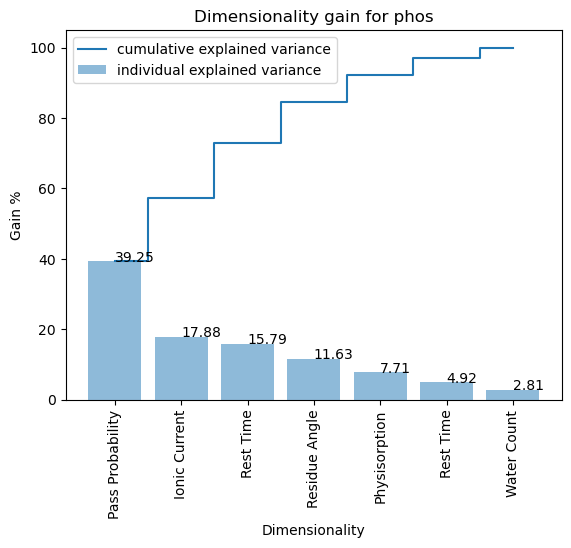

   Eigenvalues  Feature Number
0     8.864625               3
1     5.656747               5
2     3.738300               2
3     3.410344               1
4     2.983255               8
5     2.405729               6
6     1.962840               4
7     1.515086               7


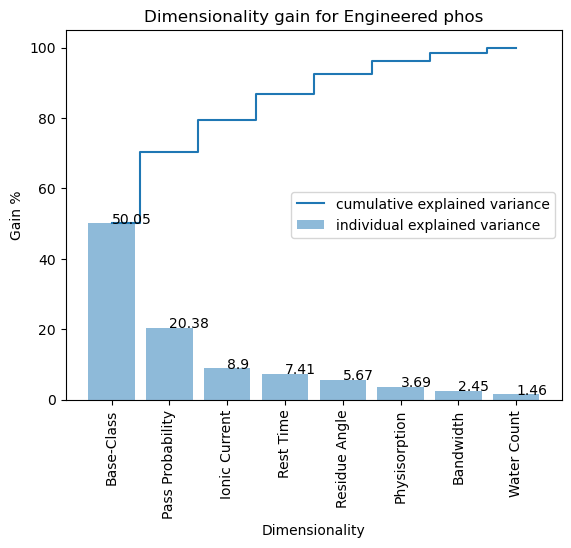

In [16]:
my_vars[f'var_weights_phos_2'] =  eval(Xphos_2, 'phos')
my_vars[f'var_weights_phos_2_e'] =  eval(Xeng_phos_2, 'phos', 1)

# Training

## functions

In [17]:
def trainers(X,y):
    (X_train, X_test, y_train, y_test) = train_test_split(X, y, test_size =  0.3, random_state=300)
    
    decTree = tree.DecisionTreeClassifier()
    decTree = decTree.fit(X_train, y_train)
    decTree_res_pred = decTree.predict(X_test)
    decTree_score = accuracy_score(y_test, decTree_res_pred)
        
    sRanFor = RandomForestClassifier(criterion='entropy')
    sRanFor = sRanFor.fit(X_train, y_train.flatten())
    sRanFor_res_pred = sRanFor.predict(X_test)
    sRanFor_score = accuracy_score(y_test, sRanFor_res_pred)
        
    lRanFor = loloClassifier()
    lRanFor = lRanFor.fit(X_train, y_train.flatten())
    lRanFor_res_pred = lRanFor.predict(X_test)
    lRanFor_score = accuracy_score(y_test, lRanFor_res_pred)
        
    svm_model_l = svm.SVC(kernel='linear')
    svm_model_l= svm_model_l.fit(X_train, y_train.flatten())
    svm_model_l_res_pred = svm_model_l.predict(X_test)
    svm_model_l_score = accuracy_score(y_test, svm_model_l_res_pred)
        
    svm_model_r = svm.SVC()
    svm_model_r= svm_model_r.fit(X_train, y_train.flatten())
    svm_model_r_res_pred = svm_model_r.predict(X_test)
    svm_model_r_score = accuracy_score(y_test, svm_model_r_res_pred)
        
    svm_model_p = svm.SVC(kernel='poly')
    svm_model_p= svm_model_p.fit(X_train, y_train.flatten())
    svm_model_p_res_pred = svm_model_p.predict(X_test)
    svm_model_p_score = accuracy_score(y_test, svm_model_p_res_pred)
        
    svm_model_s = svm.SVC(kernel='sigmoid')
    svm_model_s= svm_model_s.fit(X_train, y_train.flatten())
    svm_model_s_res_pred = svm_model_s.predict(X_test)
    svm_model_s_score = accuracy_score(y_test, svm_model_s_res_pred)
        
    totals = [decTree_score, sRanFor_score,lRanFor_score,
              svm_model_l_score,svm_model_r_score,svm_model_s_score,svm_model_p_score]
        
#     acc_mat= np.array(totals).ravel()
    pred = [ decTree_res_pred,sRanFor_res_pred, lRanFor_res_pred,svm_model_l_res_pred,
            svm_model_r_res_pred,svm_model_p_res_pred, svm_model_s_res_pred]
        
    return totals, pred, y_test

In [18]:
def training_and_plots(X,y, mode='regular', name='mxene', analysis='default', degree=None):
    """This function performs training and plots
    
    """
    # scaler = MinMaxScaler(feature_range=(0, 1))
    # X = scaler.fit_transform(X)
    its = 1
    if analysis=='polyset':
        trans = PolynomialFeatures(degree=degree)
        X = trans.fit_transform(X)
    elif analysis=='polysearch':
        its = degree
    
    acc_mat= np.zeros([7, its], dtype=float)
        
    
    groups = ['Decision Tree', 'Sk Random Forest', 'Lolopy Random Forest',
              'SVM-linear', 'SVM-RBF', 'SVM-sig','SVM-poly3']
            # totals = [decTree_score, sRanFor_score,lRanFor_score]
    
    
    for ii in range(its):
        if analysis == 'polysearch':
            n= int(ii+1)
            trans = PolynomialFeatures(degree=n)
            data = trans.fit_transform(X)
            X = data
            
        
        totals, pred, y_test = trainers(X,y)
        decTree_res_pred,sRanFor_res_pred, lRanFor_res_pred,svm_model_l_res_pred,svm_model_r_res_pred,svm_model_p_res_pred, svm_model_s_res_pred = pred
        
    
    
    if analysis!='polysearch':
        # Dec tree score per base
        if mode=='binary':
            Purine_score_dec = accuracy_score(y_test[y_test==0], decTree_res_pred.reshape(-1,1)[y_test==0])
            Pyrimidine_score_dec = accuracy_score(y_test[y_test==1], decTree_res_pred.reshape(-1,1)[y_test==1])
            
            Purine_score_sF = accuracy_score(y_test[y_test==0], sRanFor_res_pred.reshape(-1,1)[y_test==0])
            Pyrimidine_score_sF = accuracy_score(y_test[y_test==1], sRanFor_res_pred.reshape(-1,1)[y_test==1])
            
            Purine_score_lF = accuracy_score(y_test[y_test==0], lRanFor_res_pred.reshape(-1,1)[y_test==0])
            Pyrimidine_score_lF = accuracy_score(y_test[y_test==1], lRanFor_res_pred.reshape(-1,1)[y_test==1])
            
            Purine_score_svm_l = accuracy_score(y_test[y_test==0], svm_model_l_res_pred.reshape(-1,1)[y_test==0])
            Pyrimidine_score_svm_l = accuracy_score(y_test[y_test==1], svm_model_l_res_pred.reshape(-1,1)[y_test==1])
            
            Purine_score_svm_r = accuracy_score(y_test[y_test==0], svm_model_r_res_pred.reshape(-1,1)[y_test==0])
            Pyrimidine_score_svm_r = accuracy_score(y_test[y_test==1], svm_model_r_res_pred.reshape(-1,1)[y_test==1])
            
            Purine_score_svm_p = accuracy_score(y_test[y_test==0], svm_model_p_res_pred.reshape(-1,1)[y_test==0])
            Pyrimidine_score_svm_p = accuracy_score(y_test[y_test==1], svm_model_p_res_pred.reshape(-1,1)[y_test==1])
            
            Purine_score_svm_s = accuracy_score(y_test[y_test==0], svm_model_s_res_pred.reshape(-1,1)[y_test==0])
            Pyrimidine_score_svm_s = accuracy_score(y_test[y_test==1], svm_model_s_res_pred.reshape(-1,1)[y_test==1])
            
            
            totals_p = totals            
            
            Purine_scores = [Purine_score_dec,Purine_score_sF,Purine_score_lF, 
                            Purine_score_svm_l, Purine_score_svm_r, Purine_score_svm_s,Purine_score_svm_p]
            Pyrimidine_scores = [Pyrimidine_score_dec,Pyrimidine_score_sF,Pyrimidine_score_lF,
                                Pyrimidine_score_svm_l, Pyrimidine_score_svm_r, Pyrimidine_score_svm_s,Pyrimidine_score_svm_p]

            group_dic = {'Models':[*groups[:], *groups[:], *groups[:]],
                        'Scores':[*totals_p[:], *Purine_scores[:], *Pyrimidine_scores[:]],
                        'Classes': ['Totals','Totals','Totals','Totals','Totals','Totals','Totals',
                                    'Purine','Purine','Purine','Purine','Purine','Purine','Purine',
                                    'Pyrimidine','Pyrimidine','Pyrimidine','Pyrimidine','Pyrimidine','Pyrimidine','Pyrimidine']}

            group_list = [dict(zip(group_dic,t)) for t in zip(*group_dic.values())]

        else:
            A_score_dec = accuracy_score(y_test[y_test==0], decTree_res_pred.reshape(-1,1)[y_test==0])
            C_score_dec = accuracy_score(y_test[y_test==1], decTree_res_pred.reshape(-1,1)[y_test==1])
            G_score_dec = accuracy_score(y_test[y_test==2], decTree_res_pred.reshape(-1,1)[y_test==2])
            T_score_dec = accuracy_score(y_test[y_test==3], decTree_res_pred.reshape(-1,1)[y_test==3])
            
            A_score_sF = accuracy_score(y_test[y_test==0], sRanFor_res_pred.reshape(-1,1)[y_test==0])
            C_score_sF = accuracy_score(y_test[y_test==1], sRanFor_res_pred.reshape(-1,1)[y_test==1])
            G_score_sF = accuracy_score(y_test[y_test==2], sRanFor_res_pred.reshape(-1,1)[y_test==2])
            T_score_sF = accuracy_score(y_test[y_test==3], sRanFor_res_pred.reshape(-1,1)[y_test==3])
            
            A_score_lF = accuracy_score(y_test[y_test==0], lRanFor_res_pred.reshape(-1,1)[y_test==0])
            C_score_lF = accuracy_score(y_test[y_test==1], lRanFor_res_pred.reshape(-1,1)[y_test==1])
            G_score_lF = accuracy_score(y_test[y_test==2], lRanFor_res_pred.reshape(-1,1)[y_test==2])
            T_score_lF = accuracy_score(y_test[y_test==3], lRanFor_res_pred.reshape(-1,1)[y_test==3])

            A_score_svm_l = accuracy_score(y_test[y_test==0], svm_model_l_res_pred.reshape(-1,1)[y_test==0])
            C_score_svm_l = accuracy_score(y_test[y_test==1], svm_model_l_res_pred.reshape(-1,1)[y_test==1])
            G_score_svm_l = accuracy_score(y_test[y_test==2], svm_model_l_res_pred.reshape(-1,1)[y_test==2])
            T_score_svm_l = accuracy_score(y_test[y_test==3], svm_model_l_res_pred.reshape(-1,1)[y_test==3])

            A_score_svm_r = accuracy_score(y_test[y_test==0], svm_model_r_res_pred.reshape(-1,1)[y_test==0])
            C_score_svm_r = accuracy_score(y_test[y_test==1], svm_model_r_res_pred.reshape(-1,1)[y_test==1])
            G_score_svm_r = accuracy_score(y_test[y_test==2], svm_model_r_res_pred.reshape(-1,1)[y_test==2])
            T_score_svm_r = accuracy_score(y_test[y_test==3], svm_model_r_res_pred.reshape(-1,1)[y_test==3])
            
            A_score_svm_s = accuracy_score(y_test[y_test==0], svm_model_s_res_pred.reshape(-1,1)[y_test==0])
            C_score_svm_s = accuracy_score(y_test[y_test==1], svm_model_s_res_pred.reshape(-1,1)[y_test==1])
            G_score_svm_s = accuracy_score(y_test[y_test==2], svm_model_s_res_pred.reshape(-1,1)[y_test==2])
            T_score_svm_s = accuracy_score(y_test[y_test==3], svm_model_s_res_pred.reshape(-1,1)[y_test==3])
            
            A_score_svm_p = accuracy_score(y_test[y_test==0], svm_model_p_res_pred.reshape(-1,1)[y_test==0])
            C_score_svm_p = accuracy_score(y_test[y_test==1], svm_model_p_res_pred.reshape(-1,1)[y_test==1])
            G_score_svm_p = accuracy_score(y_test[y_test==2], svm_model_p_res_pred.reshape(-1,1)[y_test==2])
            T_score_svm_p = accuracy_score(y_test[y_test==3], svm_model_p_res_pred.reshape(-1,1)[y_test==3])

            
            A_scores = [A_score_dec,A_score_sF,A_score_lF,
                        A_score_svm_l,A_score_svm_r,A_score_svm_s,A_score_svm_p]
            C_scores = [C_score_dec,C_score_sF,C_score_lF,
                        C_score_svm_l,C_score_svm_r,C_score_svm_s,C_score_svm_p]
            G_scores = [G_score_dec,G_score_sF,G_score_lF,
                        G_score_svm_l,G_score_svm_r,G_score_svm_s,G_score_svm_p]
            T_scores = [T_score_dec,T_score_sF,T_score_lF,
                        T_score_svm_l,T_score_svm_r,T_score_svm_s,T_score_svm_p]

            group_dic = {'Models':[*groups[:], *groups[:], *groups[:], *groups[:], *groups[:]],
                        'Scores':[*totals[:], *A_scores[:], *C_scores[:], *G_scores[:], *T_scores[:]],
                        'Classes': ['Totals','Totals','Totals','Totals','Totals','Totals','Totals',
                                    'A','A','A','A','A','A','A',
                                    'C','C','C','C','C','C','C',
                                    'G','G','G','G','G','G','G',
                                    'T','T','T','T','T','T','T']}

            group_list = [dict(zip(group_dic,t)) for t in zip(*group_dic.values())]
        
        
        group_df = pd.DataFrame(group_list)
        # pore_type = np.chararray([group_df.shape[0],1])
        # pore_type[:] = name
        pore_type = np.repeat(name, group_df.shape[0])
        group_df['pore_type'] = pore_type.tolist()
                
        return group_df
    else:
        return acc_mat

## Data

In [19]:
pore2= 'phos'
phos_2_df = training_and_plots(Xphos_2,yphos, name=pore2)
phos_2_df_e = training_and_plots(Xeng_phos_2, yphos, name=pore2)

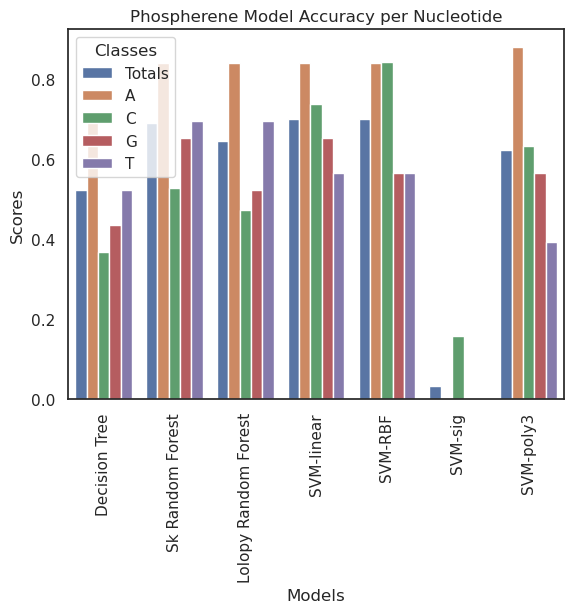

In [20]:
sns.set(style='white')

#create grouped bar chart
sns.barplot(x='Models', y='Scores', hue='Classes', data=phos_2_df).set(title='Phospherene Model Accuracy per Nucleotide') 
plt.xticks(rotation=90)
plt.show()

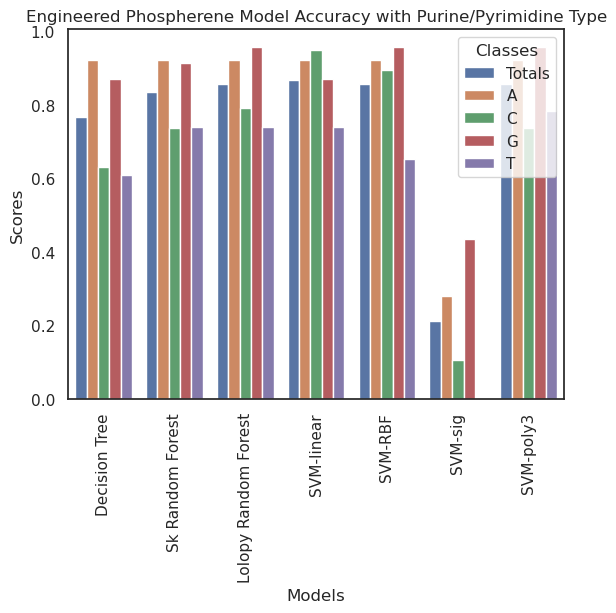

In [21]:
sns.set(style='white')

#create grouped bar chart
sns.barplot(x='Models', y='Scores', hue='Classes', data=phos_2_df_e).set(title='Engineered Phospherene Model Accuracy with Purine/Pyrimidine Type') 
#classifying only purines and pyrimidines
plt.xticks(rotation=90)
plt.show()

## Polynomial Features Search

In [22]:
def polysearch(X,y, degree= 3):
    groups = ['Degree', 'Decision Tree', 'Sk Random Forest', 'Lolopy Random Forest',
              'SVM-linear', 'SVM-RBF', 'SVM-sig','SVM-poly3']
    out_mat = np.zeros([degree, len(groups)], dtype=float)
    degs = np.linspace(1, degree, degree)
    out_mat[:,0] = degs.ravel()
    for ii in range(degree):
        trans = PolynomialFeatures(degree=ii+1)
        data = trans.fit_transform(X)
        # data_eng = trans.fit_transform(Xeng_gra)
        totals, _, _ = trainers(data,y)
        out_mat[ii, 1:]= np.array(totals).ravel()
    
    out_df = pd.DataFrame(out_mat, columns=groups)
    out_df_m = out_df.melt('Degree', var_name='Models', value_name='Accuracy')
    return out_df_m

phos


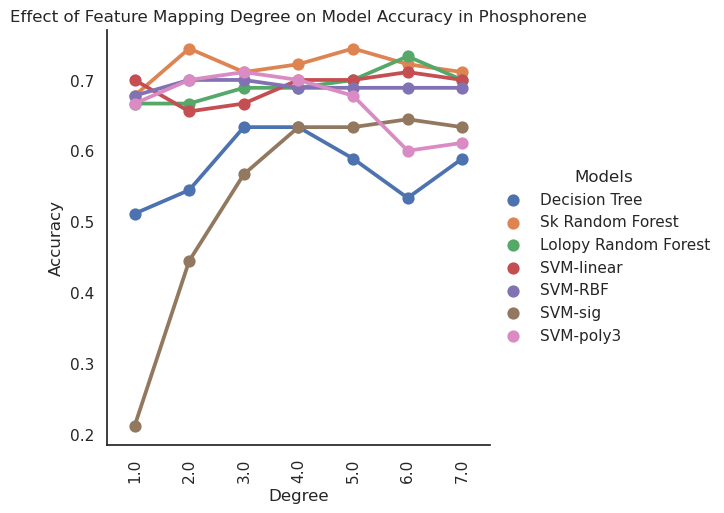

In [23]:
pore_name = ['Phosphorene']

for ind, pore in enumerate(pores):
    print(pore)
    my_vars[f'Accuracy_df_{pore}'] = polysearch(my_vars[f'X{pore}_2'], my_vars[f'y{pore}'], degree=7)
    sns.catplot(x="Degree", y="Accuracy", hue='Models', data=my_vars[f'Accuracy_df_{pore}'], kind='point').set(title=f'Effect of Feature Mapping Degree on Model Accuracy in {pore_name[ind]}') 
    plt.xticks(rotation=90)
    plt.show()

phos


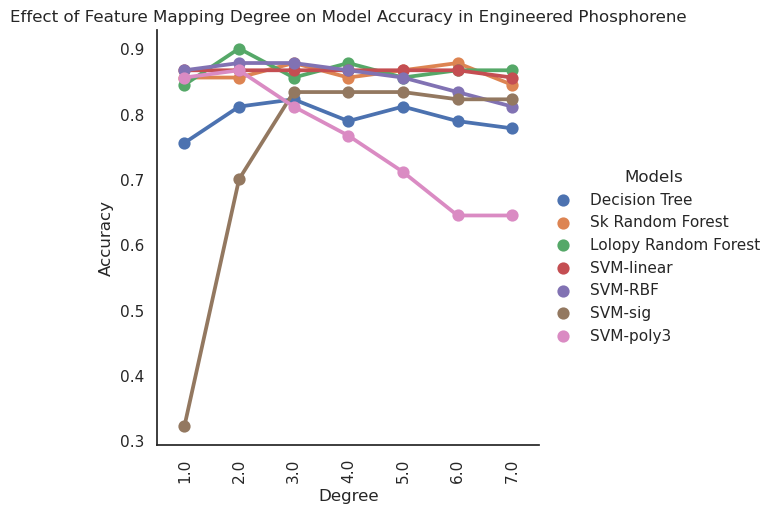

In [24]:
for ind, pore in enumerate(pores):
    print(pore)
    my_vars[f'Accuracy_df_{pore}'] = polysearch(my_vars[f'Xeng_{pore}_2'], my_vars[f'y{pore}'], degree=7)
    sns.catplot(x="Degree", y="Accuracy", hue='Models', data=my_vars[f'Accuracy_df_{pore}'], kind='point').set(title=f'Effect of Feature Mapping Degree on Model Accuracy in Engineered {pore_name[ind]}') 
    plt.xticks(rotation=90)
    plt.show()

In [25]:
phos_2_df_set2 = training_and_plots(Xphos_2,yphos, name=pore2, analysis='polyset', degree=8)

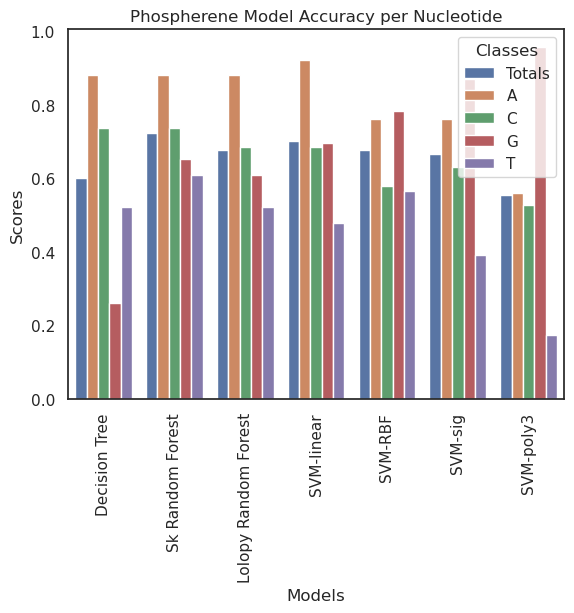

In [26]:
sns.set(style='white')

#create grouped bar chart
sns.barplot(x='Models', y='Scores', hue='Classes', data=phos_2_df_set2).set(title='Phospherene Model Accuracy per Nucleotide') 
plt.xticks(rotation=90)
plt.show()

In [27]:
phos_2_df_set5 = training_and_plots(Xphos_2,yphos, name=pore2, analysis='polyset', degree=5)

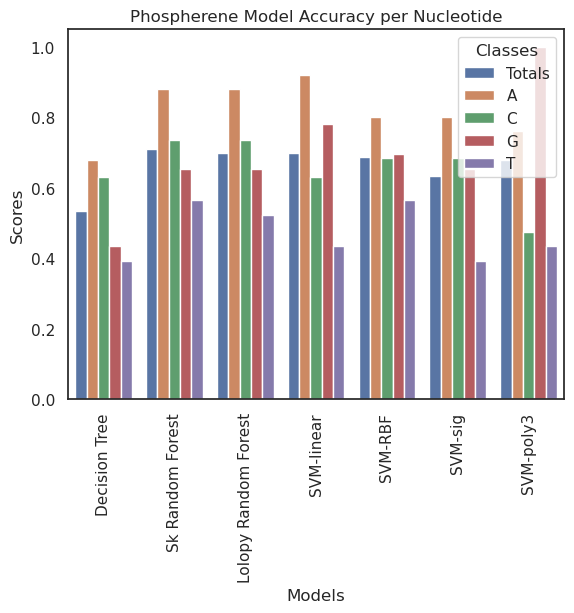

In [28]:
sns.set(style='white')

#create grouped bar chart
sns.barplot(x='Models', y='Scores', hue='Classes', data=phos_2_df_set5).set(title='Phospherene Model Accuracy per Nucleotide') 
plt.xticks(rotation=90)
plt.show()

# Math Feature engineering

Rows will be rescaled based on different math factors to see if it improves accuracy

## setup

In [29]:
def mean(data):
    data = np.asarray(data)
    data.flatten()
    M=data.mean()
    return M
def Max(data):
    data = np.asarray(data)
    data.flatten()
    Max1=data.max()
    return Max1
def Min(data):
    data = np.asarray(data)
    data.flatten()
    Min1=data.min()
    return Min1
def pp(data):
    data = np.asarray(data)
    data.flatten()
    PP=data.max()-data.min()
    return PP
def Variance(data):
    data = np.asarray(data)
    data.flatten()
    Var=data.var()
    return Var
def rms(data):
    data = np.asarray(data)
    data.flatten()
    Rms=np.sqrt(np.mean(data**2))
    return Rms
def Ab_mean(data):
    data = np.asarray(data)
    data.flatten()
    Abm=np.mean(np.absolute(data))
    return Abm
def Shapef(data):
    data = np.asarray(data)
    data.flatten()
    shapef=rms(data)/Ab_mean(data)
    return shapef
def Impulsef(data):
    data = np.asarray(data)
    data.flatten()
    impulse=Max(data)/Ab_mean(data)
    return impulse
def crestf(data):
    data = np.asarray(data)
    data.flatten()
    crest=Max(data)/rms(data)
    return crest
def SQRT_AMPL(data):
    data = np.asarray(data)
    data.flatten()
    SQRTA=(np.mean(np.sqrt(np.absolute(data))))**2
    return SQRTA
def clearancef(data):
    data = np.asarray(data)
    data.flatten()
    clrf=Max(data)/SQRT_AMPL(data)
    return clrf

In [30]:
from scipy.stats import kurtosis
from scipy.stats import skew

In [31]:
def math_feats(X):
    data = np.array(X)
    feature = []
    for i in range(X.shape[0]):
        feature.append(mean(data[i]))
        feature.append(Max(data[i]))
        feature.append(Min(data[i]))
        feature.append(pp(data[i]))
        feature.append(Variance(data[i]))
        feature.append(rms(data[i]))
        feature.append(Ab_mean(data[i]))
        feature.append(Shapef(data[i]))
        feature.append(Impulsef(data[i]))
        feature.append(crestf(data[i]))
        feature.append(clearancef(data[i]))
        K=kurtosis(data[i])
        feature.append(K)
        S=skew(data[i], axis=0, bias=False)
        feature.append(S)
        
        
    data_f = np.array(feature).reshape(X.shape[0],-1)
    # print("feature shape",data_f.shape)

    features = ['Mean', 'Max', 'Min', 'Peak to peak', 'Variance', 'RMS', 'Absolute mean', 'Shape factor', 'Impulse factor', 'Crest factor', 'Clearance factor','Kurtosis', 'Skewness',]
    # print('Features: ', features)

    features_df = pd.DataFrame(data_f,columns = features)
    # X_new = np.concatenate([X[:, 1:].reshape(X.shape[0],-1), data_f, X[:,0].reshape(X.shape[0],-1)], axis =1)
    X_new = np.concatenate([X, data_f], axis =1)
    
    
    return features_df, X_new

## Analysis

In [32]:
_, Xphos_full = math_feats(Xphos_2)
_, Xphos_full_e = math_feats(Xeng_phos_2)

     Eigenvalues  Feature Number
0   1.902157e+01              18
1   1.160786e+01              19
2   9.627742e+00              20
3   5.949714e+00               4
4   4.680057e+00               4
5   3.234559e+00               2
6   3.055973e+00               7
7   2.467161e+00               5
8   2.096240e+00              17
9   1.994785e+00               1
10  1.464176e+00               6
11  9.408805e-01              10
12  4.248764e-01              15
13  3.266901e-01               9
14  1.415193e-01              15
15  9.749565e-02              12
16  2.178397e-02              13
17  3.460111e-15              11
18  8.937884e-16              14
19  6.268189e-18              14


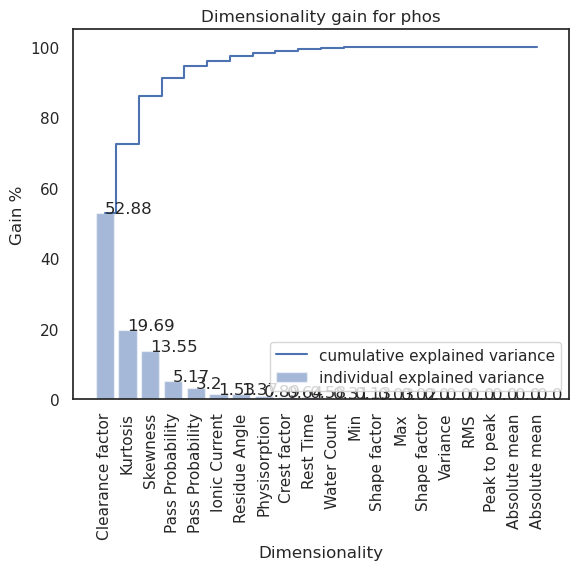

     Eigenvalues  Feature Number
0   2.263835e+01              20
1   1.707283e+01              19
2   9.991050e+00              20
3   5.843443e+00               5
4   5.039222e+00               5
5   3.704207e+00               8
6   3.361433e+00               2
7   2.840212e+00               4
8   2.255404e+00              17
9   2.140441e+00               6
10  1.972226e+00               1
11  1.489152e+00               7
12  8.390329e-01              12
13  4.994633e-01              17
14  4.092329e-01              11
15  1.608092e-01              13
16  1.084265e-01              16
17  2.081103e-02              14
18  8.563055e-15               9
19  5.575694e-16              11
20  4.871251e-18              15


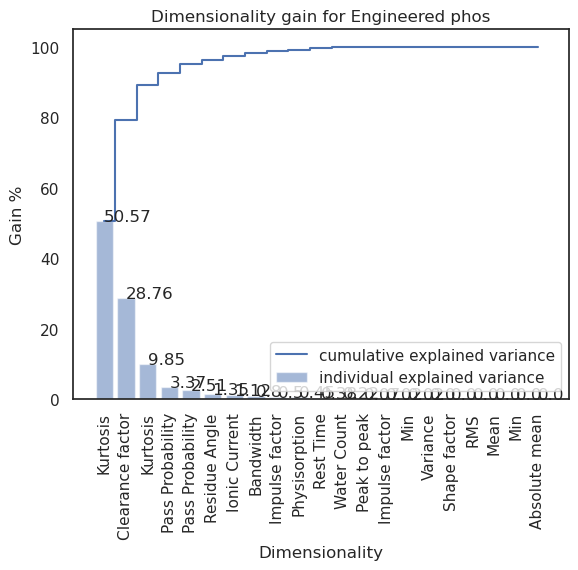

In [33]:
my_vars[f'var_weights_phos_f'] =  eval(Xphos_full, 'phos')
my_vars[f'var_weights_phos_2_e'] =  eval(Xphos_full_e, 'phos', 1)

## training

In [34]:

phos_full_df = training_and_plots(Xphos_full,yphos, name=pore2)
phos_full_df_e = training_and_plots(Xphos_full_e, yphos, name=pore2)

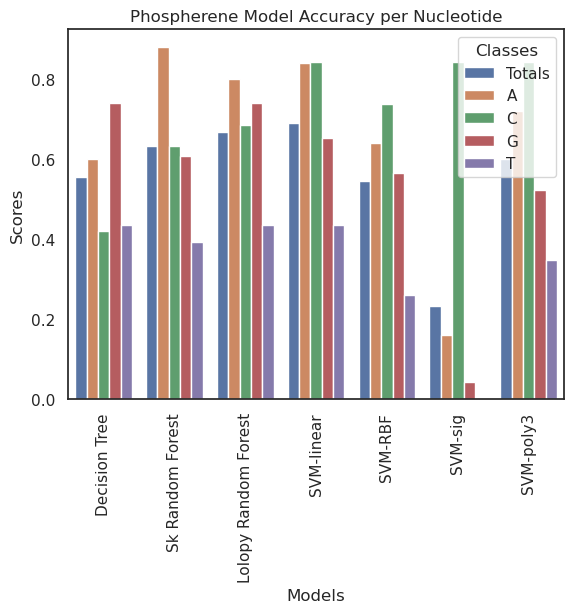

In [35]:
sns.set(style='white')

#create grouped bar chart
sns.barplot(x='Models', y='Scores', hue='Classes', data=phos_full_df).set(title='Phospherene Model Accuracy per Nucleotide') 
plt.xticks(rotation=90)
plt.show()

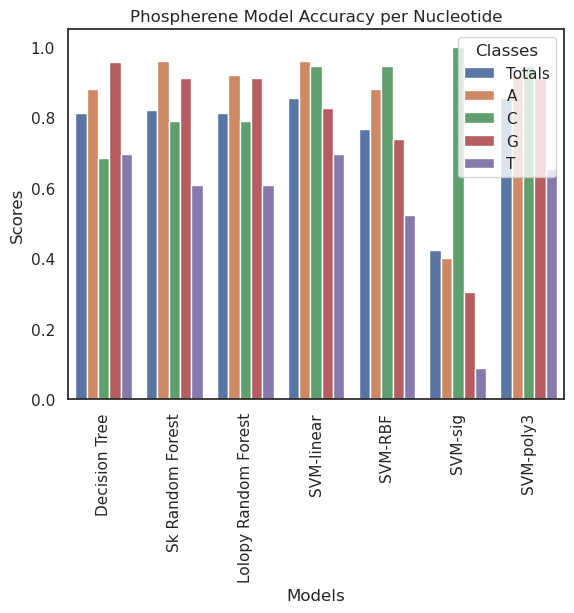

In [36]:
sns.set(style='white')

#create grouped bar chart
sns.barplot(x='Models', y='Scores', hue='Classes', data=phos_full_df_e).set(title='Phospherene Model Accuracy per Nucleotide') 
plt.xticks(rotation=90)
plt.show()

In [40]:
X_clrf = np.hstack([Xphos_2, Xphos_full[:, -1].reshape(-1, 1)])

In [41]:
phos_clrf_df = training_and_plots(X_clrf,yphos, name=pore2)

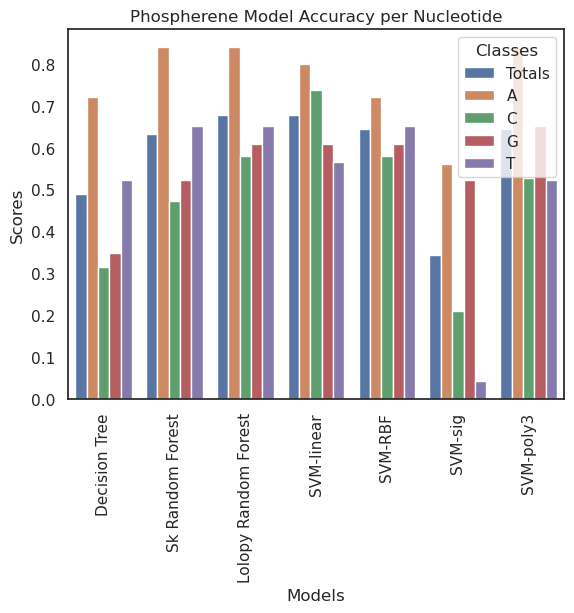

In [42]:
sns.set(style='white')

#create grouped bar chart
sns.barplot(x='Models', y='Scores', hue='Classes', data=phos_clrf_df).set(title='Phospherene Model Accuracy per Nucleotide') 
plt.xticks(rotation=90)
plt.show()